Hey there, so with the data cleaned up and ready. Below will be a list of questions im looking to tackle. The main goal for this project is to find a pattern/trend between any relevant attribute with the number of comments and ratings. I also wish to find identify demographics that use UWFlow less than others in order to focus on them for better engagement.

# Main questions

1. How does the data change when looking at courses with x number of ratings?

2. Rank departments on lowest to highest on the ratio between the number of students enrolled in the last few years against the number of ratings. i.e Number_of_Ratings/Course_Enrollment. 

3. What department/course year (100, 200, 300 etcs) has the most number of courses with less than x ratings?

4. What department has the best metrics for each metric? i.e who has the most liked courses on average and so on.

5. How different is the sentiment of the reviews between professors and the courses they teach?



I'll add more questions later on if I find anything. All the major takeaways will be published to a Power BI report

In [1]:
# Import all dependencies

import numpy as np
import math
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
from scipy.stats import boxcox, yeojohnson, skew
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in the datasets
course_df = pd.read_csv("./data files/Cleaned/cleaned_course_data2.csv")
course_df = course_df.drop(course_df.columns[12: 19], axis=1)
course_df = course_df.drop(course_df.columns[0], axis=1)

prof_df = pd.read_csv("./data files/Cleaned/cleaned_prof_data2.csv")
prof_df = prof_df.drop(prof_df.columns[0], axis=1) # since presence of unnamed column

In [3]:
course_df.head(5)

,Course_Code,Course_Name,Number_of_Ratings,Number_of_Comments,Useful,Easy,Liked,Course_Reviews,Course_Enrollment,Department,Course_Level,Useful_percentage,Easy_percentage,Liked_percentage,Positive_Score,Neutral_Score,Negative_Score
0,CS 115,Introduction to Computer Science 1,2206,114,485,243,552,"['A bird course, easy to get 90+, but it is us...",4359,Math,100,22,11,25,0.519009,0.241392,0.239599
1,MATH 135,Algebra for Honours Mathematics,1555,338,1306,669,1213,"['Very easy and interesting course, no concept...",7597,Math,100,84,43,78,0.586315,0.256309,0.157375
2,ECON 101,Introduction to Microeconomics,1398,264,881,979,629,['you can just google everything but its just ...,6247,Math,100,63,70,45,0.380631,0.292072,0.327296
3,MATH 137,Calculus 1 for Honours Mathematics,1036,211,870,580,704,"['Easy course', 'The course itself is somewhat...",8237,Math,100,84,56,68,0.349131,0.356191,0.294678
4,PD 1,Career Fundamentals,1000,189,190,800,70,['The only effect of this course is to add pre...,5790,Coop,<100,19,80,7,0.170334,0.268717,0.560948


In [4]:
prof_df.head(5)

,Professor,Courses_Taught,Professor_Reviews,Liked_%,Clear,Engaging,Number_of_Comments,Number_of_Ratings,Department,Positive_Score,Neutral_Score,Negative_Score
0,Aakar Gupta,['CS 230'],"['TA was more clear and engaging', ""Doesn't re...",0.000000,50.000000,0.0,2,2,Math,0.356152,0.175943,0.467906
1,Aaron Hutchinson,['MATH 115'],"[""There aren't any lectures this term, so I ca...",100.000000,100.000000,100.0,1,2,Math,0.718039,0.260987,0.020974
2,Aaron Kay,"['PSYCH 253', 'PSYCH 395']",['By far the best prof ive ever had. He is a g...,0.000000,0.000000,0.0,9,0,Arts,0.884515,0.068476,0.047009
3,Aaron Smith,"['MATH 115', 'MATH 211', 'PMATH 467']","[""I believe our class was the first class he t...",66.666667,66.666667,100.0,4,3,Math,0.528319,0.201090,0.270591
4,Aazar Zafar,['AFM 273'],['Explained some concepts quite well using exa...,0.000000,0.000000,0.0,5,0,Math,0.681675,0.124219,0.194106


## Question 1

 How does the data change when looking at courses with x number of ratings?

In [5]:
course_df.groupby("Department").mean().round(2).sort_values(by="Number_of_Ratings", ascending = False)

,Number_of_Ratings,Number_of_Comments,Useful,Easy,Liked,Course_Enrollment,Useful_percentage,Easy_percentage,Liked_percentage,Positive_Score,Neutral_Score,Negative_Score
Department,,,,,,,,,,,,
Coop,41.89,6.71,15.75,29.06,14.83,248.33,21.25,34.36,26.03,0.22,0.53,0.25
Math,34.60,7.21,24.95,18.11,22.17,237.55,33.00,22.85,33.21,0.25,0.53,0.22
Engineering,14.32,2.60,9.58,7.72,8.75,133.70,30.71,24.60,32.65,0.21,0.55,0.23
Science,13.66,2.94,9.95,8.36,9.12,100.04,31.85,26.54,33.82,0.23,0.55,0.22
Environment,7.95,1.76,5.49,5.25,5.22,69.70,29.45,26.46,32.89,0.23,0.56,0.21
Arts,4.58,1.07,2.73,3.31,3.16,32.67,20.81,21.30,27.47,0.20,0.59,0.21
Health,4.07,0.94,3.02,2.67,2.89,53.89,20.70,19.06,22.56,0.20,0.60,0.21


Lets focus on undergraduate classes.

In [6]:
df1 = course_df[course_df["Course_Level"].isin(["<100", "100", "200", "300", "400"])].groupby("Department").mean().round(2).sort_values(by="Number_of_Ratings", ascending = False).reset_index()
df1

,Department,Number_of_Ratings,Number_of_Comments,Useful,Easy,Liked,Course_Enrollment,Useful_percentage,Easy_percentage,Liked_percentage,Positive_Score,Neutral_Score,Negative_Score
0,Math,57.35,11.97,41.36,30.03,36.73,389.12,49.93,36.07,48.82,0.34,0.44,0.22
1,Coop,42.89,6.87,16.13,29.75,15.18,254.24,21.75,35.17,26.65,0.22,0.52,0.25
2,Engineering,22.85,4.07,15.24,12.33,13.89,207.78,42.72,34.64,44.15,0.27,0.49,0.24
3,Science,19.59,4.21,14.26,11.98,13.07,142.55,44.48,36.99,47.19,0.29,0.48,0.22
4,Environment,11.12,2.46,7.68,7.35,7.31,97.53,41.21,37.03,46.03,0.29,0.50,0.21
5,Health,6.74,1.57,5.01,4.42,4.80,89.43,33.91,31.41,36.99,0.27,0.53,0.20
6,Arts,5.13,1.20,3.06,3.71,3.53,36.50,23.21,23.76,30.63,0.21,0.58,0.21


Lets see how the data is affected by the number of courses with no ratings

In [7]:
course_df[(course_df["Number_of_Ratings"] == 0) & (course_df["Course_Level"].isin(["<100", "100", "200", "300", "400"]))].groupby("Department").count()["Course_Code"].sort_values(ascending=False)

Department
Arts           1437
Engineering     277
Science         232
Health          224
Math            211
Environment     105
Coop             52
Name: Course_Code, dtype: int64

From here we can see that Arts is heavily affected

Let's filter by courses with more than the average number of ratings for better results

In [8]:
mean_ratings = course_df["Number_of_Ratings"].mean()
undergrad_data = course_df[course_df["Course_Level"].isin(["<100", "100", "200", "300", "400"])].copy()

df_mean = undergrad_data[undergrad_data["Number_of_Ratings"] > mean_ratings].groupby("Department").mean().round(2).sort_values(by="Number_of_Ratings", ascending = False).reset_index()
df_mean

,Department,Number_of_Ratings,Number_of_Comments,Useful,Easy,Liked,Course_Enrollment,Useful_percentage,Easy_percentage,Liked_percentage,Positive_Score,Neutral_Score,Negative_Score
0,Math,152.62,31.58,110.16,80.08,97.50,993.57,72.32,52.56,66.24,0.50,0.25,0.25
1,Coop,141.97,23.14,52.97,98.97,49.51,859.54,33.14,65.32,32.68,0.34,0.29,0.37
2,Science,82.68,18.11,60.51,50.68,54.73,539.39,74.25,60.82,69.21,0.50,0.25,0.25
3,Engineering,68.34,12.33,45.95,36.90,41.17,518.49,70.09,55.63,62.60,0.45,0.28,0.27
4,Arts,54.77,13.70,31.90,40.50,36.22,338.32,62.97,71.78,69.78,0.53,0.23,0.24
5,Environment,54.23,12.62,37.08,36.52,34.79,423.50,65.96,66.71,63.17,0.54,0.21,0.25
6,Health,37.31,8.49,28.05,24.12,26.31,374.09,75.05,64.09,69.43,0.60,0.21,0.19


Immediately notice the difference between the sentiment scores. When filtered by all reviews, the neutral score used to be the dominant one. However now it's always the positive score being dominant, with the exception of the Coop department. This shows how different the data can be, and how more accurate it can be when more people participate in reviewing

#### For further clarity, let's filter it down with courses with more than 50, 100, 150 reviews

In [9]:
df_50 = undergrad_data[undergrad_data["Number_of_Ratings"] < 50].groupby("Department").mean().round(2).sort_values(by="Number_of_Ratings", ascending = False).reset_index()

In [10]:
df_200 = undergrad_data[undergrad_data["Number_of_Ratings"] < 200].groupby("Department").mean().round(2).sort_values(by="Number_of_Ratings", ascending = False).reset_index()

In [11]:
df_300 = undergrad_data[undergrad_data["Number_of_Ratings"] < 300].groupby("Department").mean().round(2).sort_values(by="Number_of_Ratings", ascending = False).reset_index()

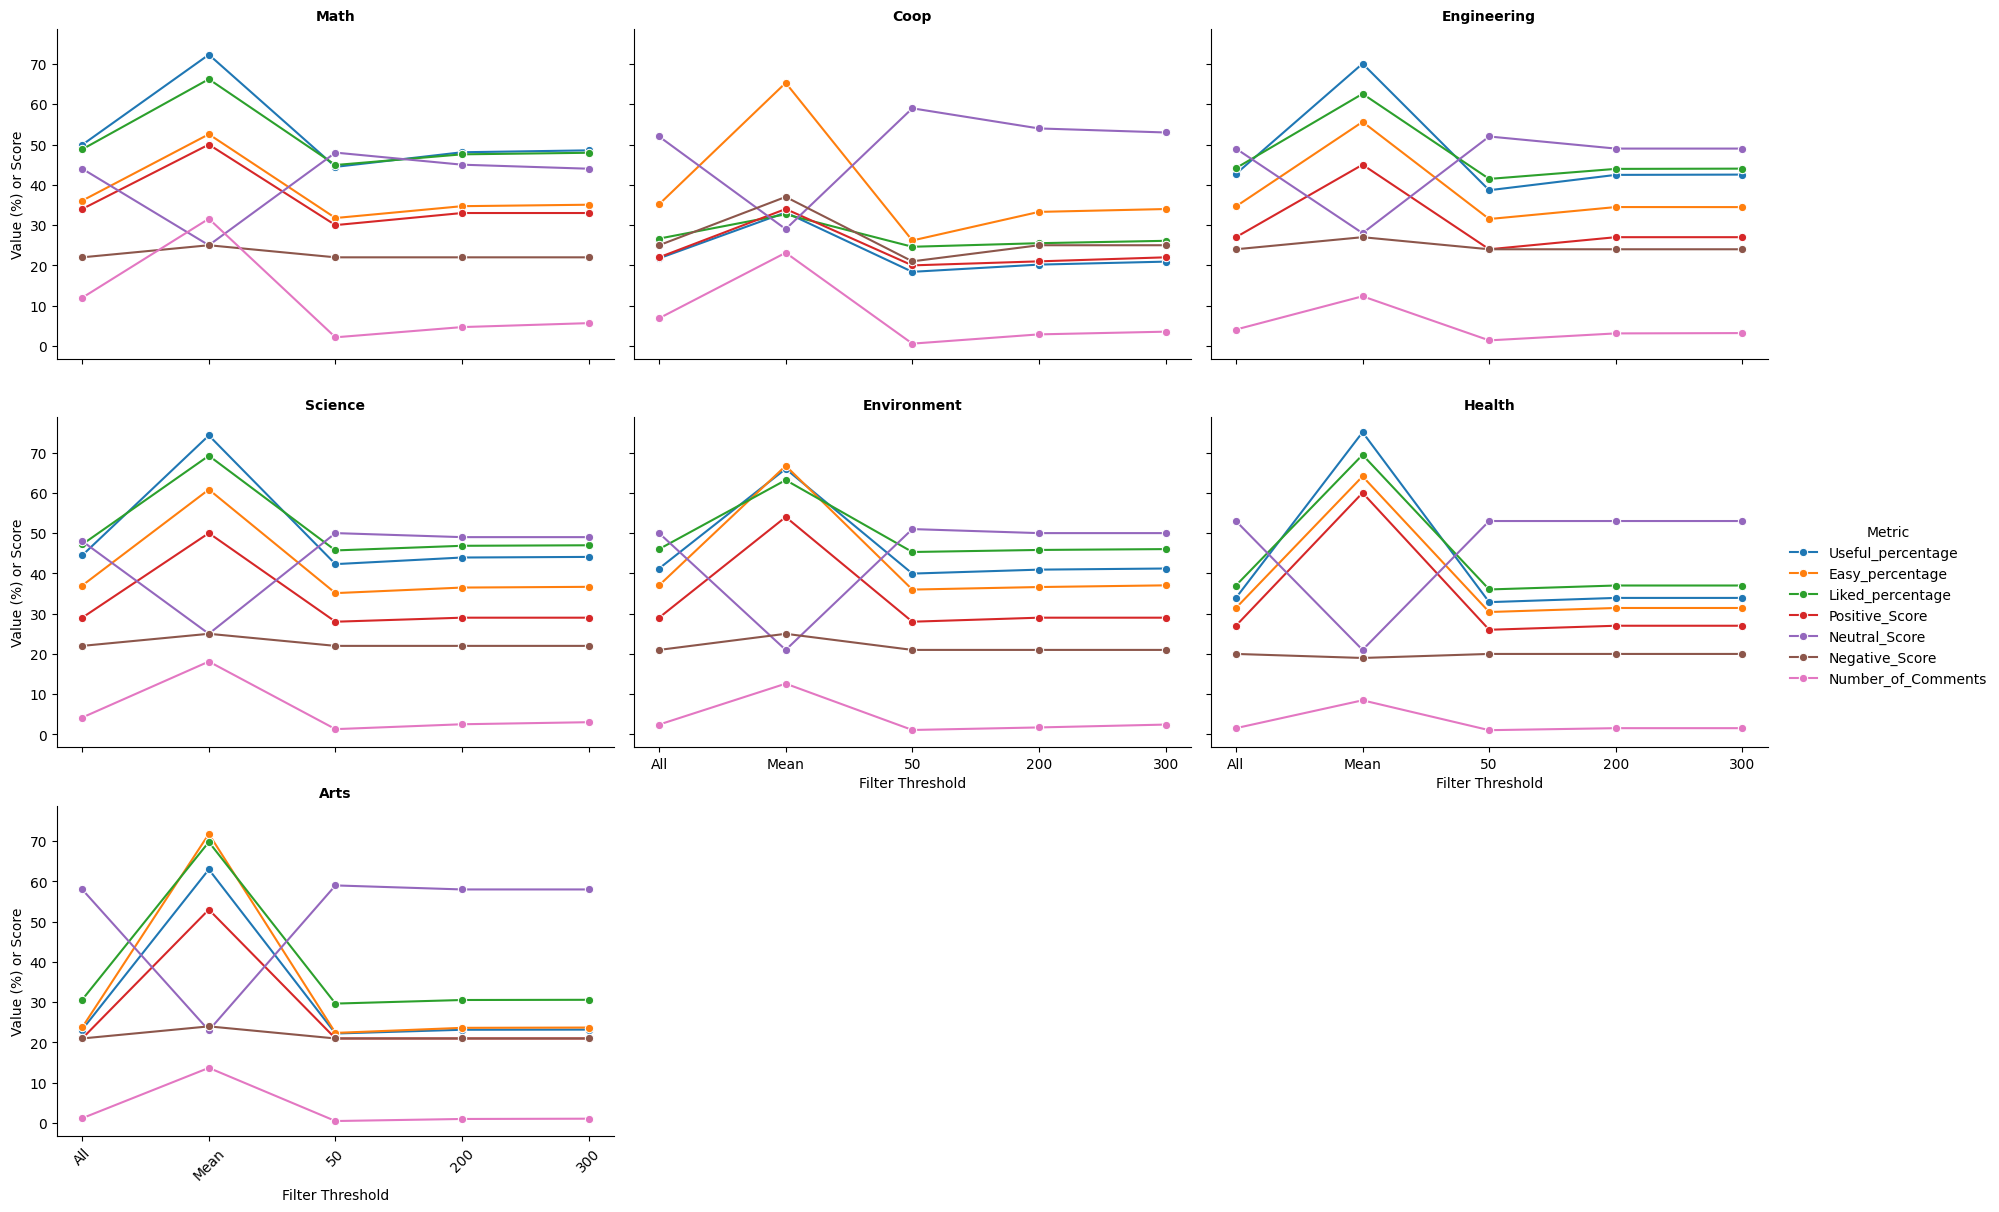

In [12]:
df1["Filter"] = "All"
df_mean["Filter"] = "Mean"
df_50["Filter"] = "50"
df_200["Filter"] = "200"
df_300["Filter"] = "300"
df_list = [df1, df_mean, df_50, df_200, df_300]
for df in df_list:
    df[["Positive_Score", "Negative_Score", "Neutral_Score"]] = df[["Positive_Score", "Negative_Score", "Neutral_Score"]] * 100
combined_df = pd.concat([df1, df_mean, df_50, df_200, df_300])

melted_df = pd.melt(combined_df, id_vars=['Department', 'Filter'],
                    value_vars=['Useful_percentage', 'Easy_percentage', 'Liked_percentage',
                                'Positive_Score', 'Neutral_Score', 'Negative_Score', "Number_of_Comments"],
                    var_name='Metric', value_name='Value')

g = sns.FacetGrid(melted_df, col="Department", hue="Metric", col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, 'Filter', 'Value', marker='o')
g.add_legend()
g.set_axis_labels("Filter Threshold", "Value (%) or Score")
g.set_titles("{col_name}", fontweight="bold")
plt.xticks(rotation=45)
plt.show()

## Question 2

Rank departments on lowest to highest on the ratio between the number of students enrolled in the last few years against the number of ratings. i.e Number_of_Ratings/Course_Enrollment.

Let's first see the courses with 0 ratings, and stack them depending on their course level

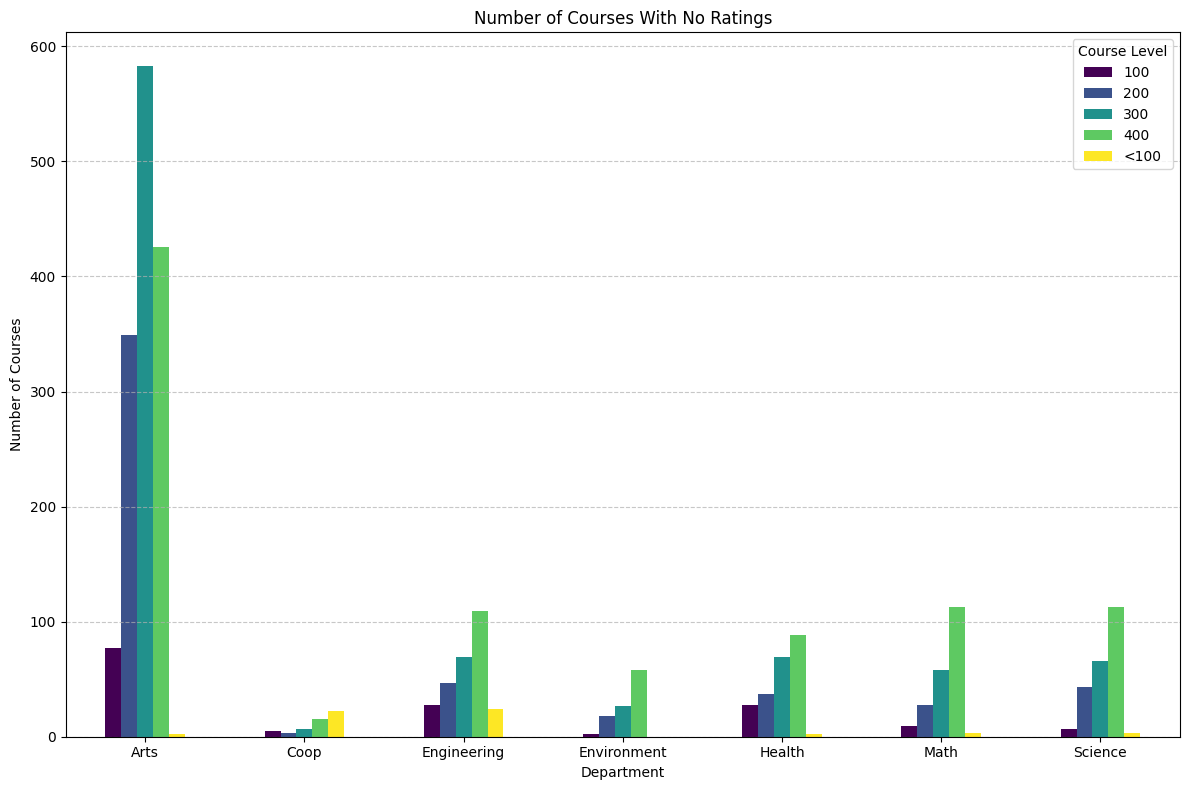

In [13]:
df_0 = course_df[(course_df["Number_of_Ratings"] == 0) & (course_df["Course_Level"].isin(["<100", "100", "200", "300", "400"]))]
aggregated_data = df_0.groupby(['Department', 'Course_Level']).size().unstack(fill_value=0)

ax = aggregated_data.plot(kind='bar', stacked=False, figsize=(12, 8), colormap='viridis')

plt.title("Number of Courses With No Ratings")
plt.xlabel('Department')
plt.ylabel('Number of Courses')
plt.xticks(rotation=0)
plt.legend(title='Course Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Notes: Ideally highlight the section with highest number of courses with 0 reviews, easier to convey information

I didn't originally store the average enrollment so I will obtain it now

In [14]:
df = pd.read_csv("./data files/Raw/Course_data.csv")
df.head(5)

,Course_Code,Course_Name,Number_of_Ratings,Number_of_Comments,Useful,Easy,Liked,Course_Reviews,Course_Enrollment
0,CS 115,Introduction to Computer Science 1,2206,NaN,22%,11%,25%,"['A bird course, easy to get 90+, but it is us...","['87/90', '83/90', '88/90', '68/90', '88/90', ..."
1,MATH 135,Algebra for Honours Mathematics,1555,338 comments,84%,43%,78%,"['Very easy and interesting course, no concept...","['55/60', '54/60', '52/60', '59/60', '52/60', ..."
2,ECON 101,Introduction to Microeconomics,1398,264 comments,63%,70%,45%,['you can just google everything but its just ...,"['252/387', '364/387', '184/220', '189/220', '..."
3,PSYCH 101,Introductory Psychology,1084,229 comments,73%,66%,78%,"[""Super fun, engaging prof and the exams are l...","['418/446', '430/446', '212/285', '142/160', '..."
4,MATH 137,Calculus 1 for Honours Mathematics,1036,211 comments,84%,56%,68%,"['Easy course', 'The course itself is somewhat...","['92/120', '93/120', '111/120', '104/120', '92..."


In [15]:
df["Course_Enrollment"] = df["Course_Enrollment"].apply(ast.literal_eval)

In [16]:
def num_lecs(row):
    if row["Course_Enrollment"][0] == "no data":
        return 0
    num_lecs = len(row["Course_Enrollment"])
    return num_lecs
df["Number_of_Lectures"] = df.apply(num_lecs, axis=1)
df.head(5)

,Course_Code,Course_Name,Number_of_Ratings,Number_of_Comments,Useful,Easy,Liked,Course_Reviews,Course_Enrollment,Number_of_Lectures
0,CS 115,Introduction to Computer Science 1,2206,NaN,22%,11%,25%,"['A bird course, easy to get 90+, but it is us...","[87/90, 83/90, 88/90, 68/90, 88/90, 56/84, 88/...",62
1,MATH 135,Algebra for Honours Mathematics,1555,338 comments,84%,43%,78%,"['Very easy and interesting course, no concept...","[55/60, 54/60, 52/60, 59/60, 52/60, 57/60, 59/...",73
2,ECON 101,Introduction to Microeconomics,1398,264 comments,63%,70%,45%,['you can just google everything but its just ...,"[252/387, 364/387, 184/220, 189/220, 132/220, ...",24
3,PSYCH 101,Introductory Psychology,1084,229 comments,73%,66%,78%,"[""Super fun, engaging prof and the exams are l...","[418/446, 430/446, 212/285, 142/160, 66/285, 1...",15
4,MATH 137,Calculus 1 for Honours Mathematics,1036,211 comments,84%,56%,68%,"['Easy course', 'The course itself is somewhat...","[92/120, 93/120, 111/120, 104/120, 92/120, 103...",52


In [17]:
df = df[["Course_Code", "Number_of_Lectures"]]
course_df = pd.merge(course_df, df, on="Course_Code")
course_df.head()

,Course_Code,Course_Name,Number_of_Ratings,Number_of_Comments,Useful,Easy,Liked,Course_Reviews,Course_Enrollment,Department,Course_Level,Useful_percentage,Easy_percentage,Liked_percentage,Positive_Score,Neutral_Score,Negative_Score,Number_of_Lectures
0,CS 115,Introduction to Computer Science 1,2206,114,485,243,552,"['A bird course, easy to get 90+, but it is us...",4359,Math,100,22,11,25,0.519009,0.241392,0.239599,62
1,MATH 135,Algebra for Honours Mathematics,1555,338,1306,669,1213,"['Very easy and interesting course, no concept...",7597,Math,100,84,43,78,0.586315,0.256309,0.157375,73
2,ECON 101,Introduction to Microeconomics,1398,264,881,979,629,['you can just google everything but its just ...,6247,Math,100,63,70,45,0.380631,0.292072,0.327296,24
3,MATH 137,Calculus 1 for Honours Mathematics,1036,211,870,580,704,"['Easy course', 'The course itself is somewhat...",8237,Math,100,84,56,68,0.349131,0.356191,0.294678,52
4,PD 1,Career Fundamentals,1000,189,190,800,70,['The only effect of this course is to add pre...,5790,Coop,<100,19,80,7,0.170334,0.268717,0.560948,9


In [18]:
course_df["Average_Enrollment"] = course_df["Course_Enrollment"] / course_df["Number_of_Lectures"]
course_df.to_csv("./data files/Cleaned/cleaned_course_data2.csv")
course_df.head(5)

,Course_Code,Course_Name,Number_of_Ratings,Number_of_Comments,Useful,Easy,Liked,Course_Reviews,Course_Enrollment,Department,Course_Level,Useful_percentage,Easy_percentage,Liked_percentage,Positive_Score,Neutral_Score,Negative_Score,Number_of_Lectures,Average_Enrollment
0,CS 115,Introduction to Computer Science 1,2206,114,485,243,552,"['A bird course, easy to get 90+, but it is us...",4359,Math,100,22,11,25,0.519009,0.241392,0.239599,62,70.306452
1,MATH 135,Algebra for Honours Mathematics,1555,338,1306,669,1213,"['Very easy and interesting course, no concept...",7597,Math,100,84,43,78,0.586315,0.256309,0.157375,73,104.068493
2,ECON 101,Introduction to Microeconomics,1398,264,881,979,629,['you can just google everything but its just ...,6247,Math,100,63,70,45,0.380631,0.292072,0.327296,24,260.291667
3,MATH 137,Calculus 1 for Honours Mathematics,1036,211,870,580,704,"['Easy course', 'The course itself is somewhat...",8237,Math,100,84,56,68,0.349131,0.356191,0.294678,52,158.403846
4,PD 1,Career Fundamentals,1000,189,190,800,70,['The only effect of this course is to add pre...,5790,Coop,<100,19,80,7,0.170334,0.268717,0.560948,9,643.333333


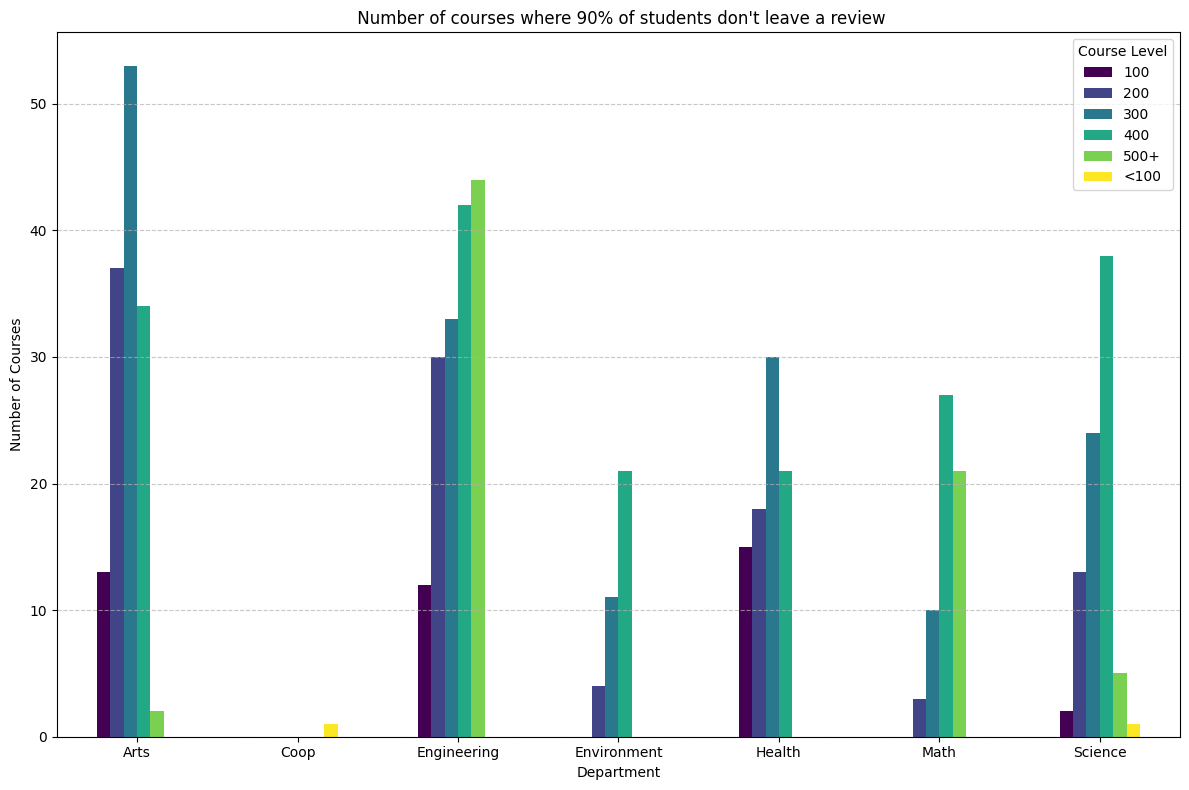

In [19]:
percentage = 10/100
df_avg = course_df[(course_df["Number_of_Ratings"] < course_df["Average_Enrollment"] * percentage) & (course_df["Number_of_Ratings"] != 0)]
aggregated_data = df_avg.groupby(['Department', 'Course_Level']).size().unstack(fill_value=0)

ax = aggregated_data.plot(kind='bar', stacked=False, figsize=(12, 8), colormap='viridis')

plt.title(f" Number of courses where {100 - round(percentage * 100)}% of students don't leave a review")
plt.xlabel('Department')
plt.ylabel('Number of Courses')
plt.xticks(rotation=0)
plt.legend(title='Course Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
df = course_df.groupby("Department").mean().reset_index()
df["Num_ratings : Avg_enrollment"] = df["Number_of_Ratings"] / df["Average_Enrollment"]
df["Num_ratings : Avg_enrollment"] = df["Num_ratings : Avg_enrollment"].apply(lambda x: f"1/{math.ceil(1/x)}")
df[["Department", "Number_of_Ratings", "Average_Enrollment", "Num_ratings : Avg_enrollment"]]

,Department,Number_of_Ratings,Average_Enrollment,Num_ratings : Avg_enrollment
0,Arts,4.578907,31.537661,1/7
1,Coop,41.891473,196.002778,1/5
2,Engineering,14.320822,65.778888,1/5
3,Environment,7.946015,50.169493,1/7
4,Health,4.066667,79.673938,1/20
5,Math,34.597947,56.343073,1/2
6,Science,13.661442,57.592855,1/5


In [21]:
df = course_df.groupby(["Department", "Course_Level"]).mean()
df['Average_Enrollment'] = pd.to_numeric(df['Average_Enrollment'], errors='coerce')
df['Average_Enrollment'] = df['Average_Enrollment'].fillna(0)
df["Num_ratings : Avg_enrollment"] = df["Number_of_Ratings"] / df["Average_Enrollment"]
df["Num_ratings : Avg_enrollment"] = df["Num_ratings : Avg_enrollment"].apply(
    lambda x: f"1/{math.ceil(1/x)}" if pd.notna(x) else np.nan
)
df[["Number_of_Ratings", "Average_Enrollment", "Num_ratings : Avg_enrollment"]]

Number_of_Ratings  Average_Enrollment  \
Department  Course_Level                                          
Arts        100                   27.745174           49.225760   
            200                    4.973721           31.858771   
            300                    1.193357           22.505416   
            400                    0.375242           20.557986   
            500+                   0.042105           20.033333   
            <100                   8.444444           15.652381   
Coop        100                   40.142857           37.916667   
            200                   60.789474           33.200000   
            300                   13.894737           29.750000   
            400                    6.250000           16.166667   
            500+                   0.000000            0.000000   
            <100                  70.608696          274.394074   
Engineering 100                   65.891156           80.566383   
            200                   25.608696           78.506273   
            300                   13.957806           69.073657   
            400                    6.200000           60.144588   
            500+                   0.636531           32.777066   
            <100                   0.000000            0.000000   
Environment 100                   71.684211           81.998913   
            200                   20.100000           76.561290   
            300                    4.364583           36.355100   
            400                    1.009709           31.600000   
            500+                   0.000000            0.000000   
Health      100                   17.121212          108.927756   
            200                   12.053763          103.630842   
            300                    3.697842           86.450321   
            400                    1.861842           36.736142   
            500+                   0.006711            0.000000   
            <100                   0.000000            0.000000   
Math        100                  254.104651           90.622032   
            200                   77.617021           77.113148   
            300                   25.604878           57.348353   
            400                    8.507463           34.785408   
            500+                   0.156989           21.660355   
            <100                  11.500000          327.666667   
Science     100                   97.918033          100.048669   
            200                   27.345029           69.012468   
            300                    9.104712           50.817328   
            400                    2.732218           39.689538   
            500+                   0.103093           44.722222   
            <100                   0.750000           60.000000   

                         Num_ratings : Avg_enrollment  
Department  Course_Level                               
Arts        100                                   1/2  
            200                                   1/7  
            300                                  1/19  
            400                                  1/55  
            500+                                1/476  
            <100                                  1/2  
Coop        100                                   1/1  
            200                                   1/1  
            300                                   1/3  
            400                                   1/3  
            500+                                  NaN  
            <100                                  1/4  
Engineering 100                                   1/2  
            200                                   1/4  
            300                                   1/5  
            400                                  1/10  
            500+                                 1/52  
            <100                                  NaN  
Environment 100         

## Question 3

What department/course year (100, 200, 300 etcs) has the most number of courses with less than x ratings?

I'll answer this by seeing how the average number of ratings fluctuates over the years

In [22]:
df = course_df[course_df['Course_Level'].isin(["100", "200", "300", "400"])]
df = df.groupby(["Department","Course_Level"]).mean().round().reset_index()
df[["Department", "Course_Level", "Number_of_Ratings", "Average_Enrollment"]]

,Department,Course_Level,Number_of_Ratings,Average_Enrollment
0,Arts,100,28.0,49.0
1,Arts,200,5.0,32.0
2,Arts,300,1.0,23.0
3,Arts,400,0.0,21.0
4,Coop,100,40.0,38.0
5,Coop,200,61.0,33.0
6,Coop,300,14.0,30.0
7,Coop,400,6.0,16.0
8,Engineering,100,66.0,81.0
9,Engineering,200,26.0,79.0


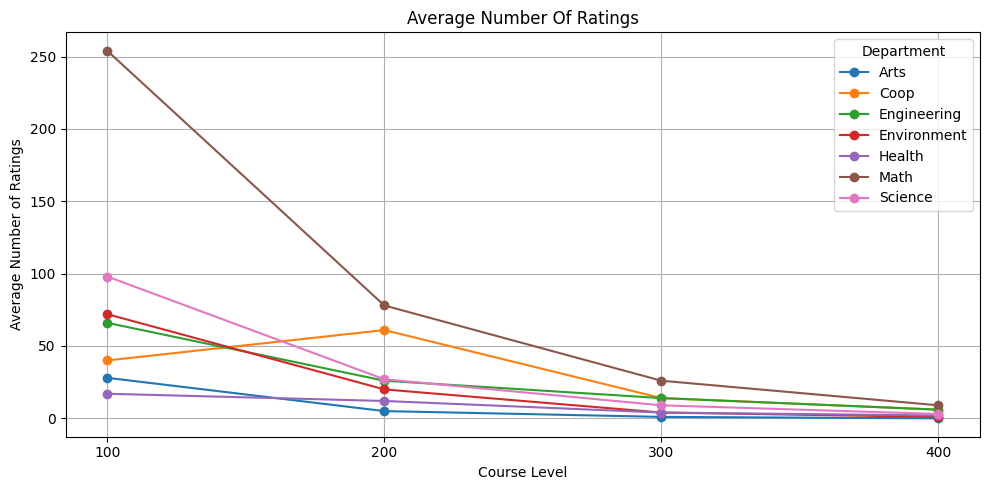

In [23]:
departments = df['Department'].unique()

plt.figure(figsize=(10, 5))

for department in departments:
    df_dept = df[df['Department'] == department]
    plt.plot(df_dept['Course_Level'], df_dept['Number_of_Ratings'], marker='o', label=department)

plt.title('Average Number Of Ratings')
plt.xlabel('Course Level')
plt.ylabel('Average Number of Ratings')
plt.legend(title='Department')
plt.grid(True)
plt.xticks(ticks=sorted(df['Course_Level'].unique()))
plt.tight_layout()
plt.show()

This tells us that in general the average number of ratings decreases as you go up the years. So upper years are not participating as much it seems